In [70]:
##Including Imports
#!pip3 install mpu
import pandas as pd
import math
import numpy as np
import mpu
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as stats
#from distfit import distfit
from pprint import pprint

In [71]:
data = pd.read_csv("data.csv")
df = data.drop(data.columns[[11, 12, 13, 14]], axis=1)
df.head()

,EVENTID,AUTHOR,DATE,TIME,LAT,LON,DEPTH,DEPFIX,AUTHOR.1,TYPE,MAG
0,16957943,ISC,1907-01-04,05:19:11.80,1.8725,94.2091,15.0,TRUE,ISC,MS,7.8
1,913990,ISC,1914-06-25,19:07:25.91,-3.9242,101.8203,35.0,TRUE,ISC,MS,7.6
2,913286,ISC,1918-09-22,09:55:00.13,-1.4570,100.0902,35.0,TRUE,ISC,MS,6.5
3,912712,ISC,1919-01-18,05:52:24.87,-4.5766,101.4670,35.0,TRUE,ISC,MS,6.3
4,912756,ISC,1919-04-02,00:34:59.58,-5.4963,104.4870,20.0,TRUE,ISC,MS,6.5


In [72]:
#Current Dimension of DataFrame
df.shape
df.describe()

,EVENTID,LAT,LON,DEPTH,MAG
count,3.470000e+02,347.000000,347.000000,347.000000,347.000000
mean,6.191350e+07,-0.495112,99.101616,36.664553,6.289914
std,1.767335e+08,4.928445,4.250671,22.127160,0.346722
min,6.744800e+04,-9.986000,90.335900,10.000000,6.000000
25%,8.589300e+05,-4.666200,95.756450,25.000000,6.000000
50%,1.739574e+06,-0.921300,99.095900,31.100000,6.200000
75%,1.069965e+07,3.269400,102.111800,41.700000,6.400000
max,6.166402e+08,9.427100,109.802600,181.500000,7.800000


In [73]:
def get_dist(lat1, lang1, lat2, lang2):
    dist = mpu.haversine_distance((lat1, lang1), (lat2, lang2))
    return abs(dist)

def get_diff_days(date1, date2):
    date_format = "%Y-%m-%d"
    return abs((datetime.strptime(date1, date_format) - datetime.strptime(date2, date_format)).days)
    
def get_window(M):
    r = math.exp(-1.024 + 0.804 * M)
    t = math.exp(-2.870 + 1.235 * M)
    return r, t

def filtering(df):
    for index1, row1 in df.iterrows():
        M = row1["MAG"]
        r = math.exp(-1.024 + 0.804 * M)
        t = math.exp(-2.870 + 1.235 * M)
        for index2, row2 in df.iterrows():
            if (row2["MAG"] <= row1["MAG"] and (index1 is not index2) and 
                    (get_dist(row1["LAT"], row1["LON"], row2["LAT"], row2["LON"]) <= r+60) 
                       and (get_diff_days(row1["DATE"], row2["DATE"]) <= t+15)):
                    df.drop(index2,inplace=True)

In [74]:
filtering(df)

In [75]:
df.head()

,EVENTID,AUTHOR,DATE,TIME,LAT,LON,DEPTH,DEPFIX,AUTHOR.1,TYPE,MAG
0,16957943,ISC,1907-01-04,05:19:11.80,1.8725,94.2091,15.0,TRUE,ISC,MS,7.8
1,913990,ISC,1914-06-25,19:07:25.91,-3.9242,101.8203,35.0,TRUE,ISC,MS,7.6
2,913286,ISC,1918-09-22,09:55:00.13,-1.4570,100.0902,35.0,TRUE,ISC,MS,6.5
3,912712,ISC,1919-01-18,05:52:24.87,-4.5766,101.4670,35.0,TRUE,ISC,MS,6.3
4,912756,ISC,1919-04-02,00:34:59.58,-5.4963,104.4870,20.0,TRUE,ISC,MS,6.5


In [76]:
#Current shape of DataFrame
df.shape

(164, 11)

In [77]:
date_format = "%Y/%m/%d"

int_time = []
int_time.append(0)
date_values = df["DATE"].values
for i in range(len(date_values)):
    if(i != 0):
        int_time.append(get_diff_days(date_values[i], date_values[i-1]))

df["INTEREVENT TIME"] = int_time
df["INTEREVENT TIME"] /= (12*30)
df = df[df["INTEREVENT TIME"] != 0]

In [78]:
df.head()

,EVENTID,AUTHOR,DATE,TIME,LAT,LON,DEPTH,DEPFIX,AUTHOR.1,TYPE,MAG,INTEREVENT TIME
1,913990,ISC,1914-06-25,19:07:25.91,-3.9242,101.8203,35.0,TRUE,ISC,MS,7.6,7.580556
2,913286,ISC,1918-09-22,09:55:00.13,-1.4570,100.0902,35.0,TRUE,ISC,MS,6.5,4.305556
3,912712,ISC,1919-01-18,05:52:24.87,-4.5766,101.4670,35.0,TRUE,ISC,MS,6.3,0.327778
4,912756,ISC,1919-04-02,00:34:59.58,-5.4963,104.4870,20.0,TRUE,ISC,MS,6.5,0.205556
5,912979,ISC,1919-10-12,21:48:31.74,-4.1786,101.7521,25.0,TRUE,ISC,MS,6.5,0.536111


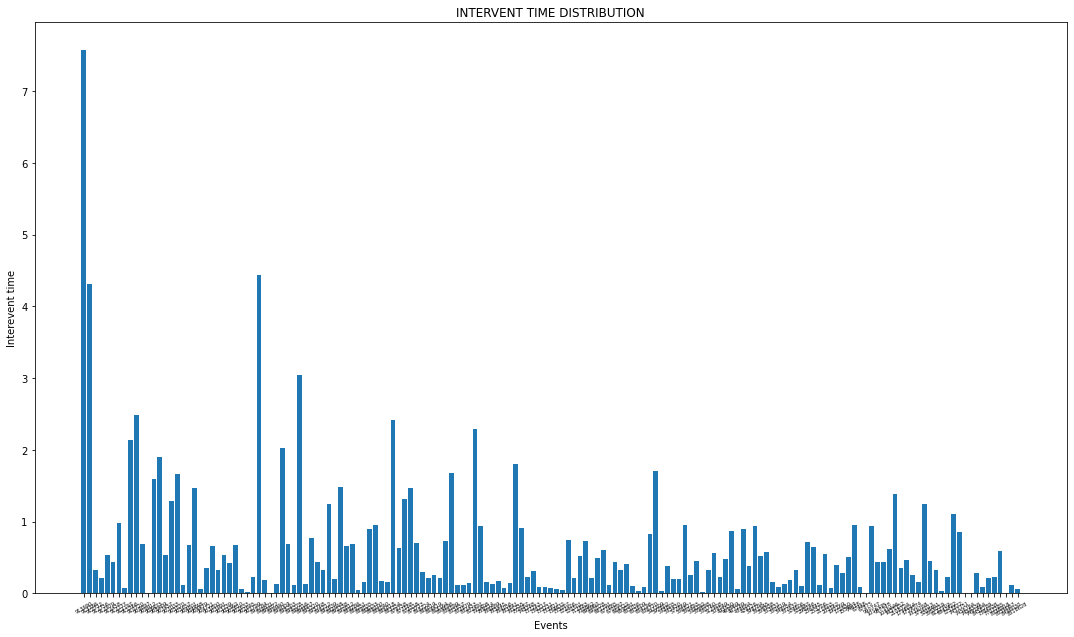

In [79]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)

index = np.arange(len(df))
plt.xlabel('Events', fontsize=10)
plt.ylabel('Interevent time', fontsize=10)
plt.xticks(index, df["EVENTID"].values, fontsize=5, rotation=30)
plt.title('INTERVENT TIME DISTRIBUTION')
plt.bar(index, df["INTEREVENT TIME"])
plt.show()

In [80]:
df2 = pd.DataFrame()
df2["INTEREVENT TIME"] = df["INTEREVENT TIME"]
df2.to_csv("interevent_time.csv")

/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:1972: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


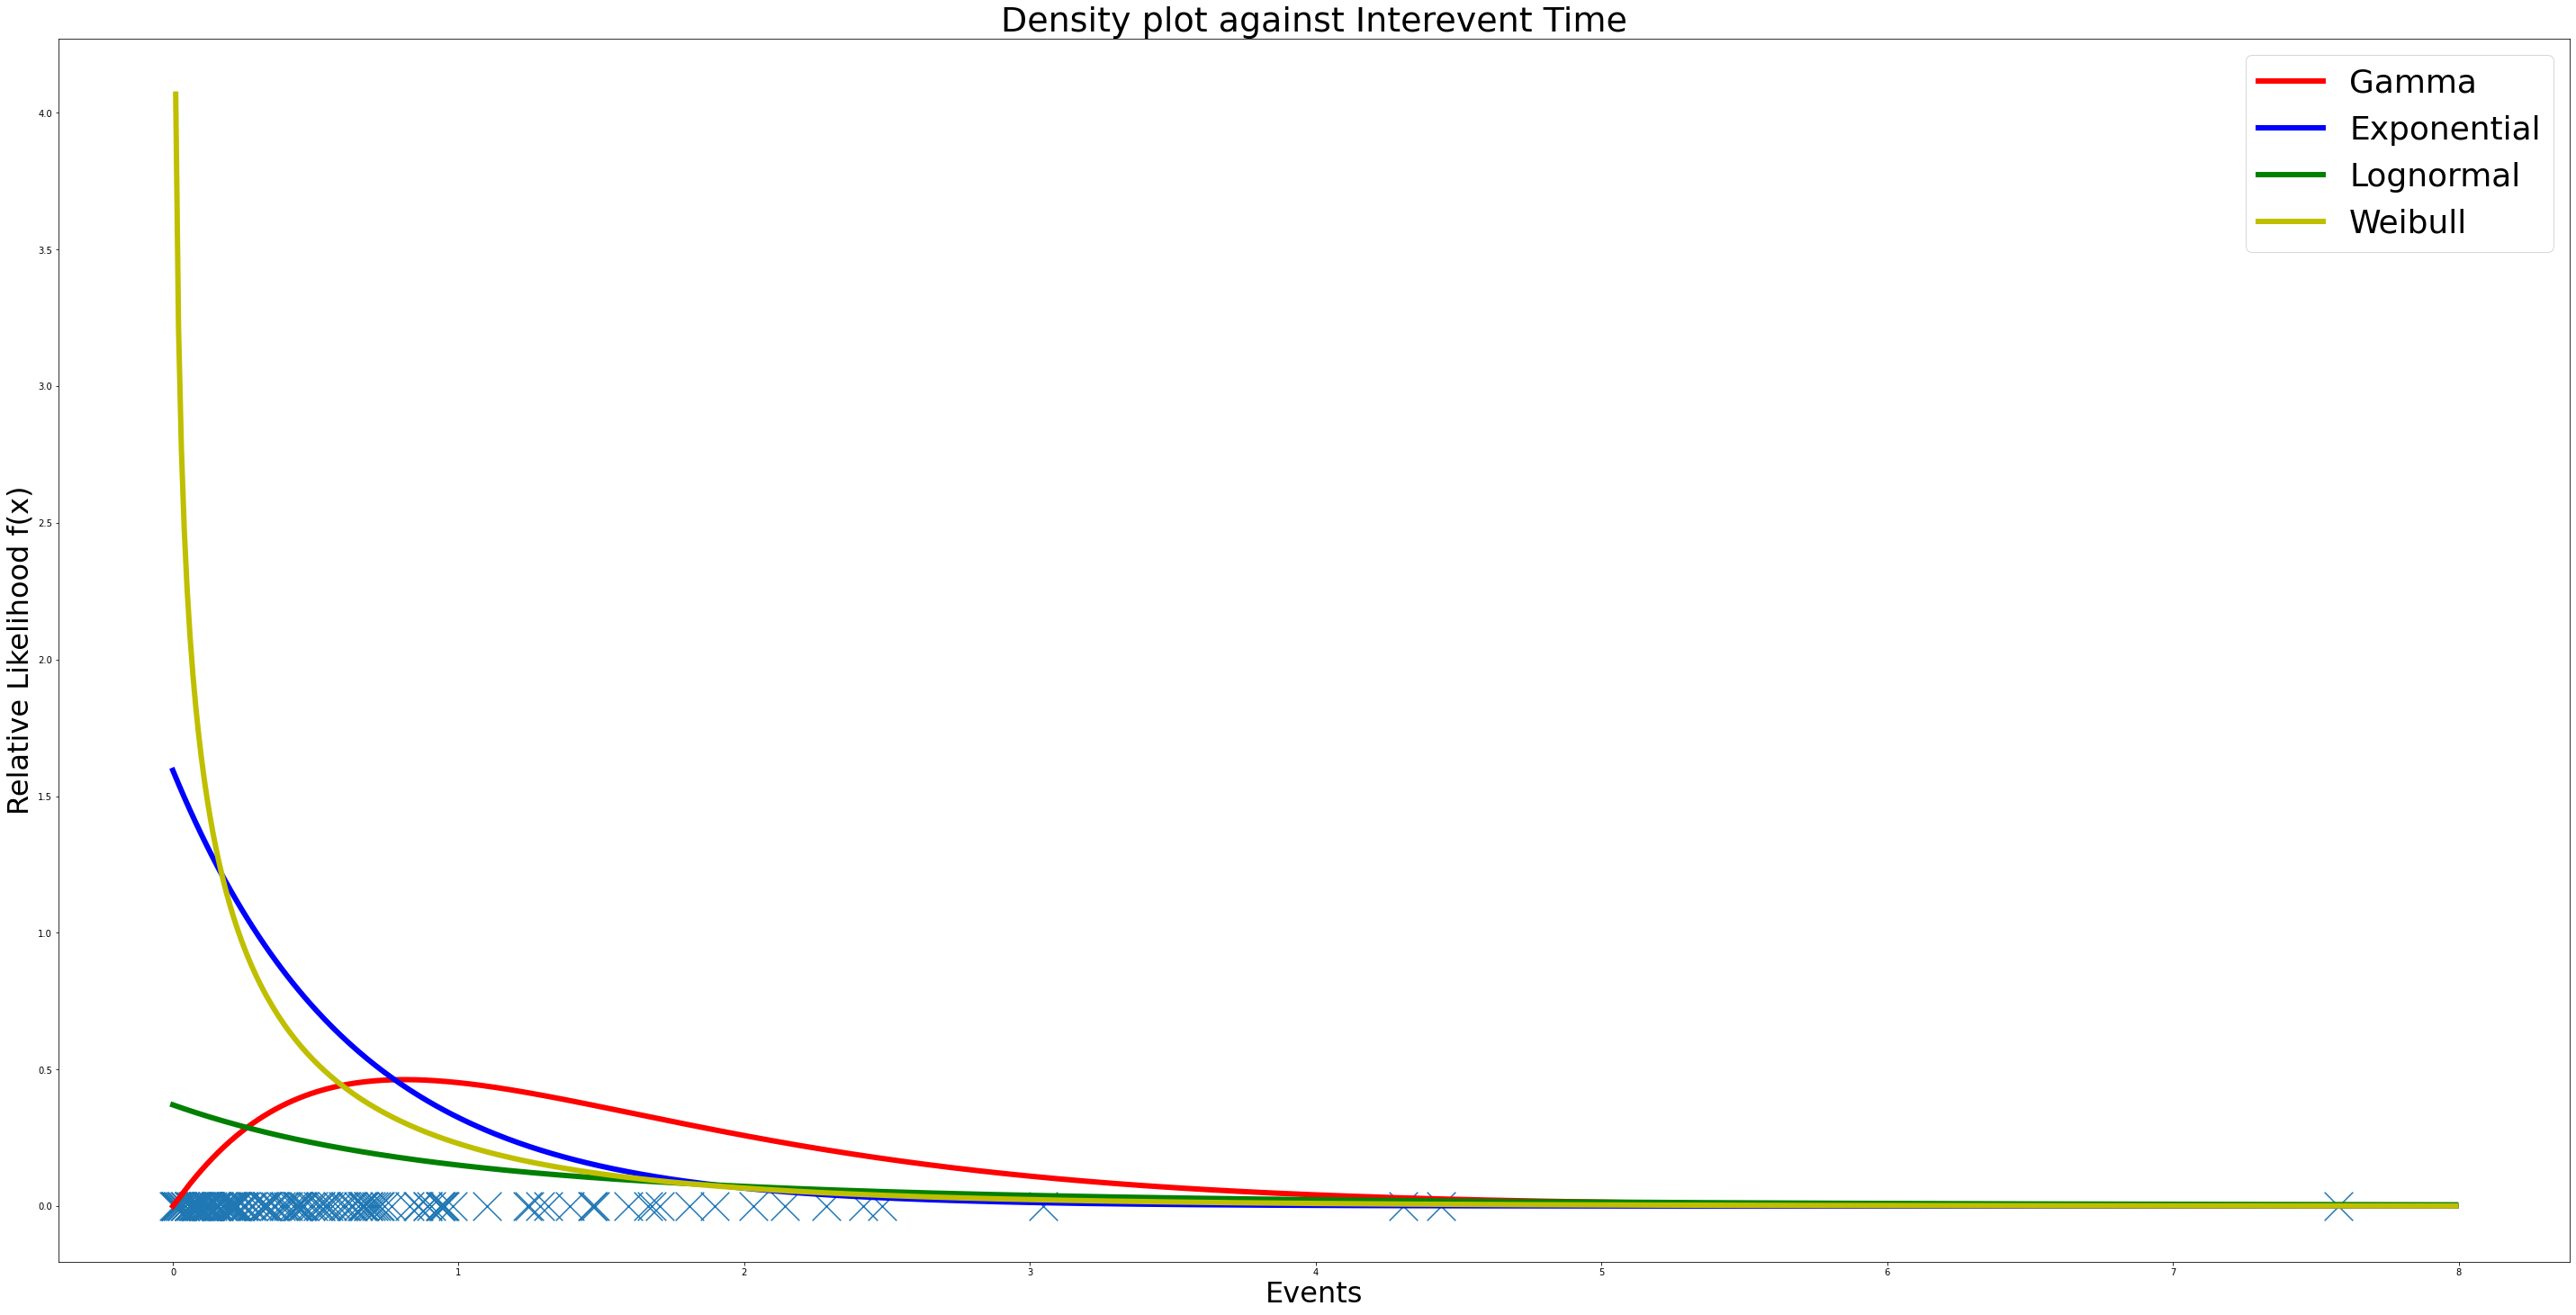

In [81]:
##MoM
fig = plt.gcf()
fig.set_size_inches(50, 25, forward=True)
x = np.arange(0, 8, 0.01)
index = np.arange(len(df))
plt.xlabel('Events', fontsize=32)
plt.ylabel('Relative Likelihood f(x)', fontsize=32)
plt.title('Density plot against Interevent Time', fontsize =38)
plt.scatter(df["INTEREVENT TIME"], np.zeros(len(df)), s = 1000, marker= 'x')
plt.plot(x, stats.gamma.pdf(x, a = (1/0.4913494), scale=0.7833695), "r", linewidth=6, label = "Gamma")
plt.plot(x, stats.expon.pdf(x, scale = (1/1.594322)), "b", linewidth=6, label = "Exponential")
plt.plot(x, stats.lognorm.pdf(x, loc = -1.021589, s = 1.053699), "g", linewidth=6, label = "Lognormal")
plt.plot(x, stats.weibull_min.pdf(x, c = 0.7153732, scale = 0.5056480), "y", linewidth=6, label = "Weibull")
plt.legend(prop={'size': 36})
plt.show()

/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:1972: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


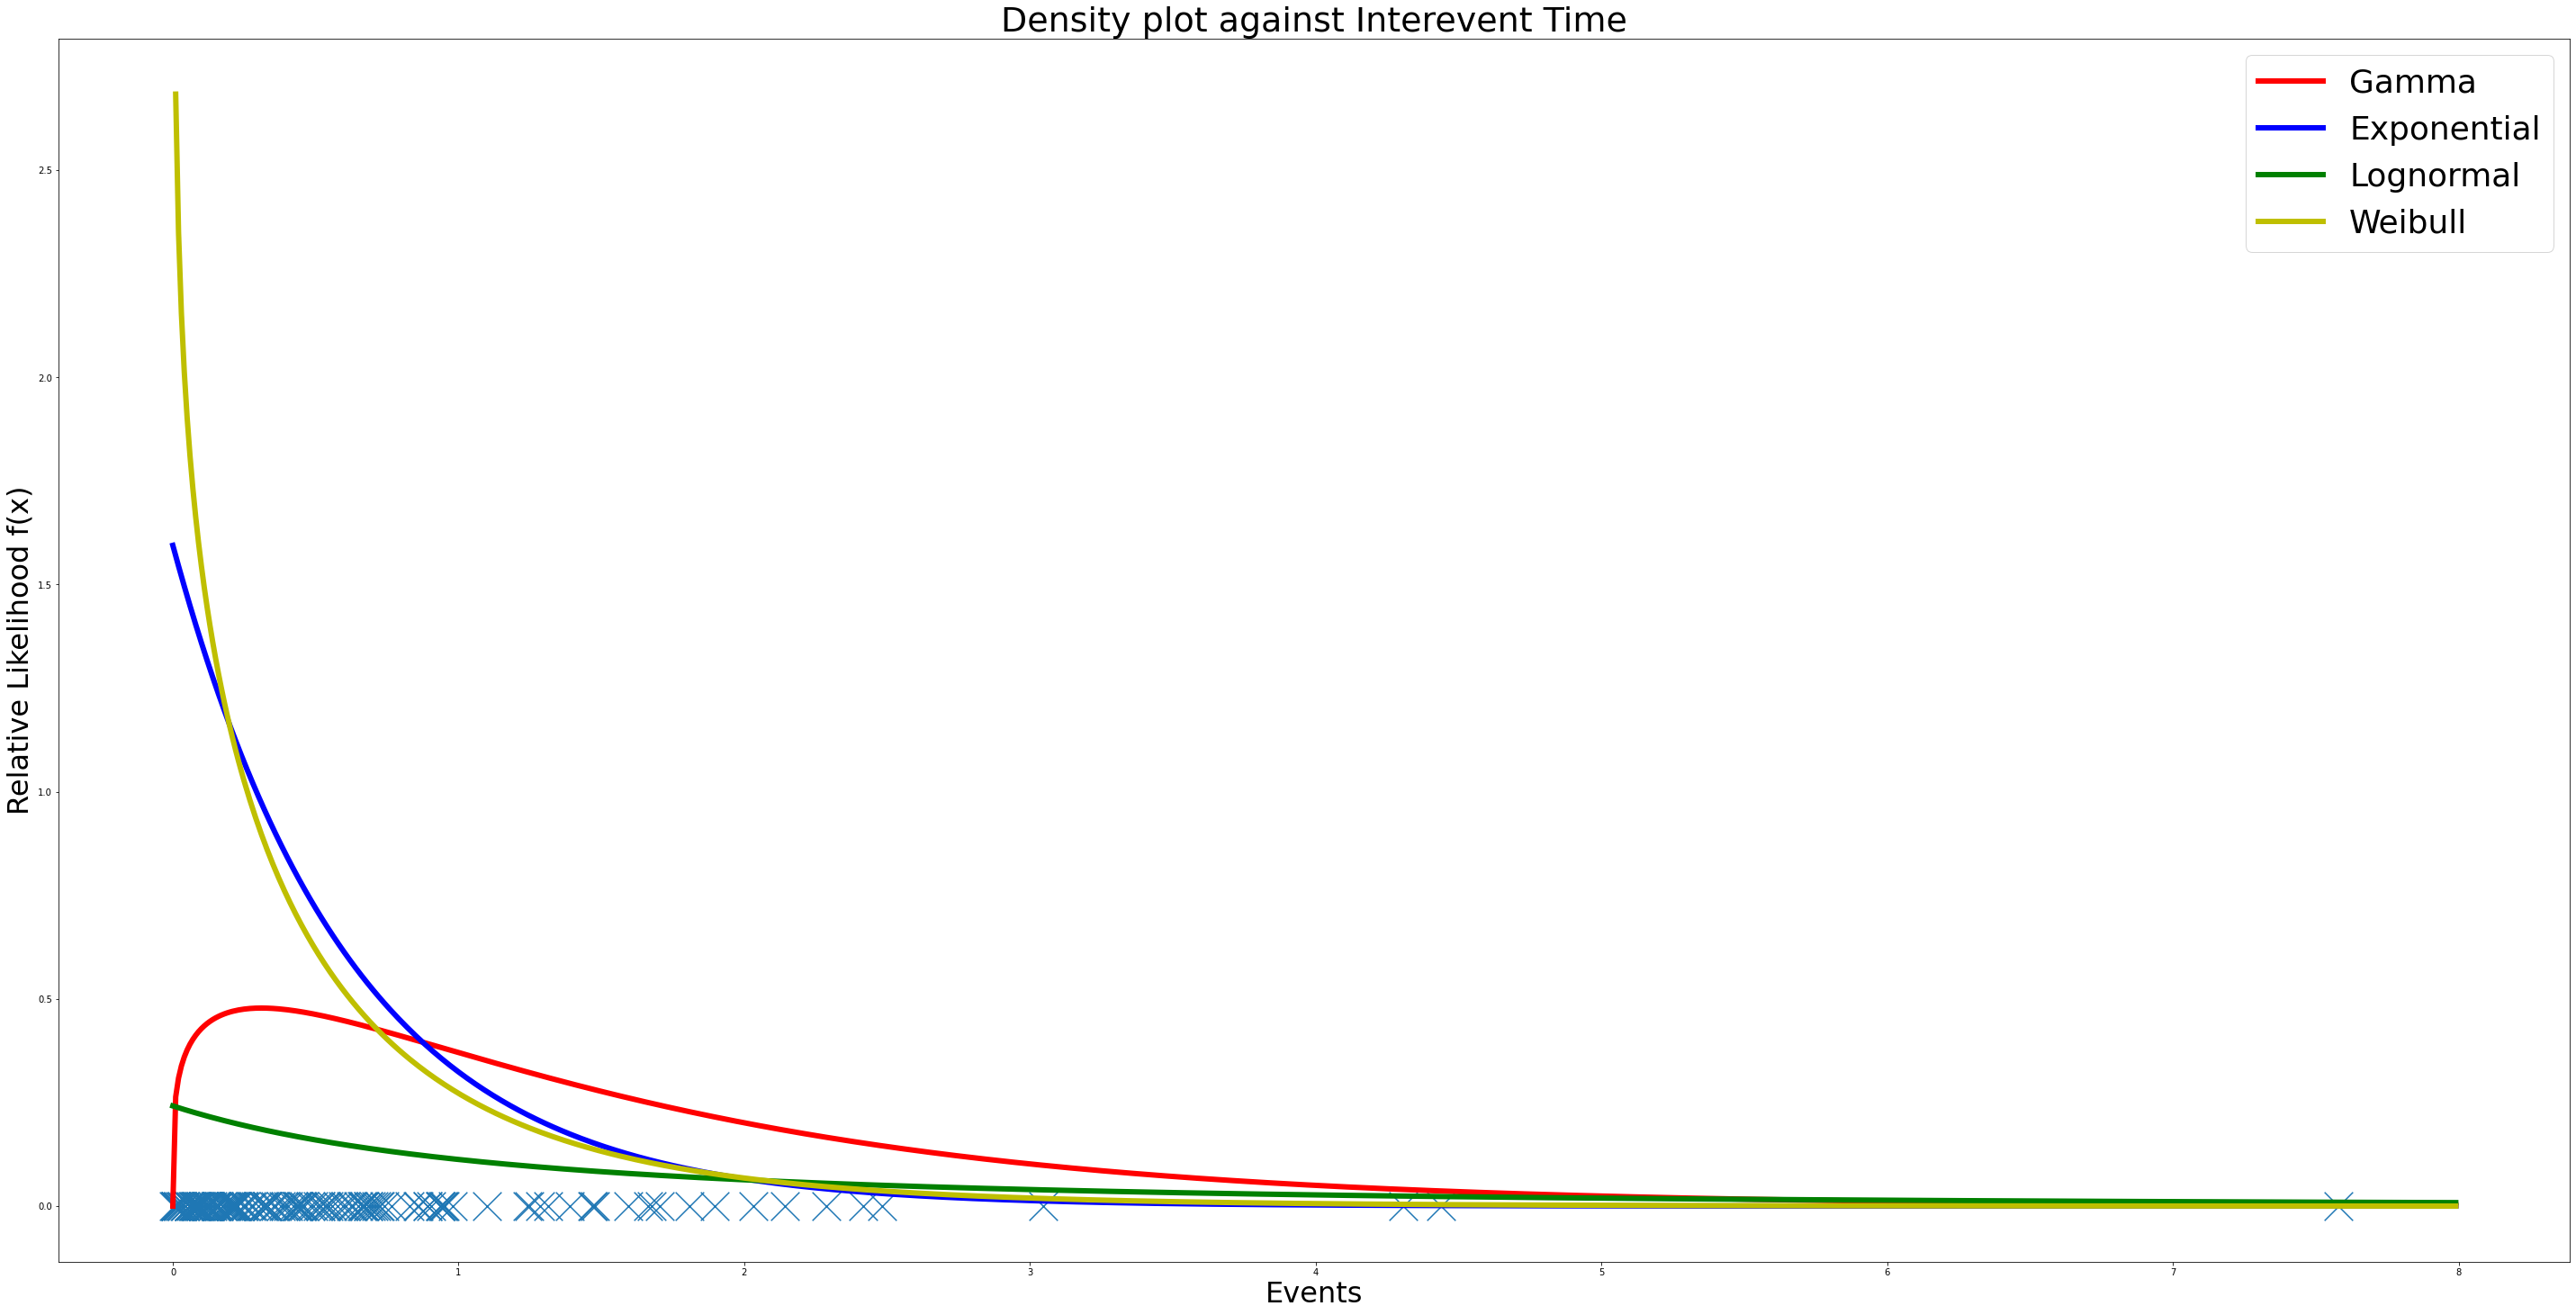

In [82]:
##MLE
fig = plt.gcf()
fig.set_size_inches(50, 25, forward=True)

index = np.arange(len(df))
plt.xlabel('Events', fontsize=32)
plt.ylabel('Relative Likelihood f(x)', fontsize=32)
plt.title('Density plot against Interevent Time', fontsize =38)
plt.scatter(df["INTEREVENT TIME"], np.zeros(len(df)), s = 1000, marker= 'x')
plt.plot(x, stats.gamma.pdf(x, a = (1/0.8055547), scale = 1.2842414), "r", label = "Gamma", linewidth=6)
plt.plot(x, stats.expon.pdf(x, scale = (1/1.594322)), "b", label = "Exponential", linewidth=6)
plt.plot(x, stats.lognorm.pdf(x, loc = -1.202592, s = 1.359600), "g", label = "Lognormal", linewidth=6)
plt.plot(x, stats.weibull_min.pdf(x, c = 0.8456672, scale = 0.5691232), "y", label = "Weibull", linewidth=6)
plt.legend(prop={'size': 36})
plt.show()

In [94]:
dists = {
    'exponential': {
        'st': st.expon,
        'mle': [1.594323],
        'mme': [1.594322],
    },'gamma': {
        'st': st.gamma,
        'mle': [0.8055547, 1.2842414],
        'mme': [0.4913494, 0.7833695],
    }, 'weibull': {
        'st': st.weibull_min,
        'mle': [0.8456672, 0.5691232],
        'mme': [0.7153732, 0.5056480],
    }, 'lognormal': {
        'st': st.lognorm,
        'mle': [-1.202592,1.359600],
        'mme': [-1.021589, 1.053699],
    },
}

def cdf_exponential_mle(t):
    return dists['exponential']['st'].cdf(t,
        scale=1/dists['exponential']['mle'][0])

def cdf_gamma_mle(t):
    return dists['gamma']['st'].cdf(t,
        a=dists['gamma']['mle'][0], scale=1/dists['gamma']['mle'][1])

def cdf_lnorm_mle(t):
    return dists['lognormal']['st'].cdf(t,
        dists['lognormal']['mle'][1], 0, np.exp(dists['lognormal']['mle'][0]))

def cdf_weibull_mle(t):
    return dists['weibull']['st'].cdf(t,
        c=dists['weibull']['mle'][0], scale=1/dists['gamma']['mle'][1])

def cdf_exponential_mom(t):
    return dists['exponential']['st'].cdf(t,
        scale=1/dists['exponential']['mme'][0])

def cdf_gamma_mom(t):
    return dists['gamma']['st'].cdf(t,
        a=dists['gamma']['mme'][0], scale=1/dists['gamma']['mme'][1])

def cdf_lnorm_mom(t):
    return dists['lognormal']['st'].cdf(t,
        dists['lognormal']['mme'][1], 0, np.exp(dists['lognormal']['mme'][0]))

def cdf_weibull_mom(t):
    return dists['weibull']['st'].cdf(t,
        c=dists['weibull']['mme'][0], scale=1/dists['gamma']['mme'][1])

def c_prob(v, cdf, t):
    return (cdf(t+v) - cdf(t)) / (1 - cdf(t))

In [95]:
v = np.arange(0, 50, 0.001)

In [96]:
def plot_mle(elapsed_times, v):  
    fig = plt.gcf()
    fig.set_size_inches(18, 15, forward=True)
    
    plt.figure(figsize=(12,8))
    plt.subplot(221)
    for t in elapsed_times:
        plt.plot(v+t, c_prob(v, cdf_exponential_mle, t), "b")
        plt.xlabel('Elapsed Time', fontsize=10)
        plt.ylabel('Conditional Probability', fontsize=10)
        plt.title('Exponential')
    plt.subplot(222)
    for t in elapsed_times:
        plt.plot(v+t, c_prob(v, cdf_gamma_mle, t), "b")
        plt.xlabel('Elapsed Time', fontsize=10)
        plt.ylabel('Conditional Probability', fontsize=10)
        plt.title('Gamma')
    plt.subplot(223)
    for t in elapsed_times:
        plt.plot(v+t, c_prob(v, cdf_lnorm_mle, t), "b")
        plt.xlabel('Elapsed Time', fontsize=10)
        plt.ylabel('Conditional Probability', fontsize=10)
        plt.title('Lognormal')
    plt.subplot(224)
    for t in elapsed_times:
        plt.plot(v+t, c_prob(v, cdf_weibull_mle, t), "b")
        plt.xlabel('Elapsed Time', fontsize=10)
        plt.ylabel('Conditional Probability', fontsize=10)
        plt.title('Weibull')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
    plt.suptitle('Conditional Probability Curves For MLE parameters', fontsize = 15)
    plt.show()
    
def plot_mom(elapsed_times, v):  
    fig = plt.gcf()
    fig.set_size_inches(18, 15, forward=True)
    
    plt.figure(figsize=(12,8))
    plt.subplot(221)
    for t in elapsed_times:
        plt.plot(v+t, c_prob(v, cdf_exponential_mom, t), "b")
        plt.xlabel('Elapsed Time', fontsize=10)
        plt.ylabel('Conditional Probability', fontsize=10)
        plt.title('Exponential')
    plt.subplot(222)
    for t in elapsed_times:
        plt.plot(v+t, c_prob(v, cdf_gamma_mom, t), "b")
        plt.xlabel('Elapsed Time', fontsize=10)
        plt.ylabel('Conditional Probability', fontsize=10)
        plt.title('Gamma')
    plt.subplot(223)
    for t in elapsed_times:
        plt.plot(v+t, c_prob(v, cdf_lnorm_mom, t), "b")
        plt.xlabel('Elapsed Time', fontsize=10)
        plt.ylabel('Conditional Probability', fontsize=10)
        plt.title('Lognormal')
    plt.subplot(224)
    for t in elapsed_times:
        plt.plot(v+t, c_prob(v, cdf_weibull_mom, t), "b")
        plt.xlabel('Elapsed Time', fontsize=10)
        plt.ylabel('Conditional Probability', fontsize=10)
        plt.title('Weibull')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
    plt.suptitle('Conditional Probability Curves For MOM parameters', fontsize = 15)
    plt.show()

<Figure size 1296x1080 with 0 Axes>

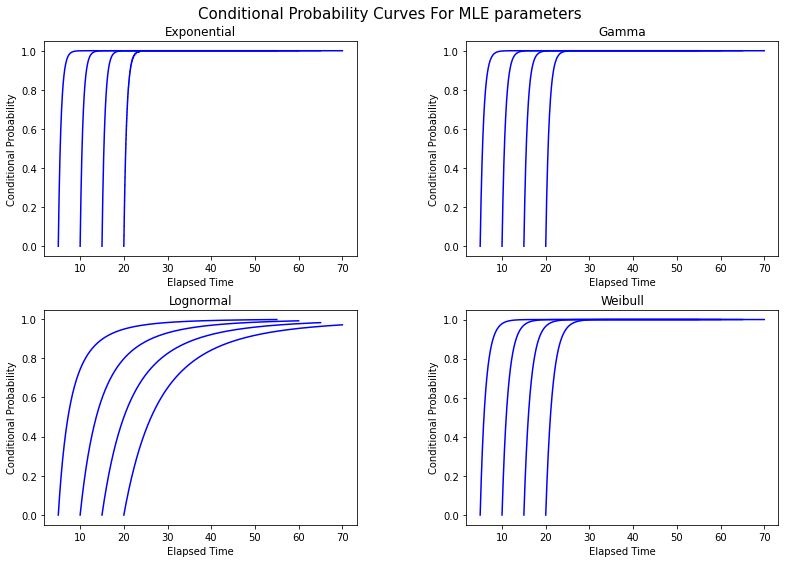

<Figure size 1296x1080 with 0 Axes>

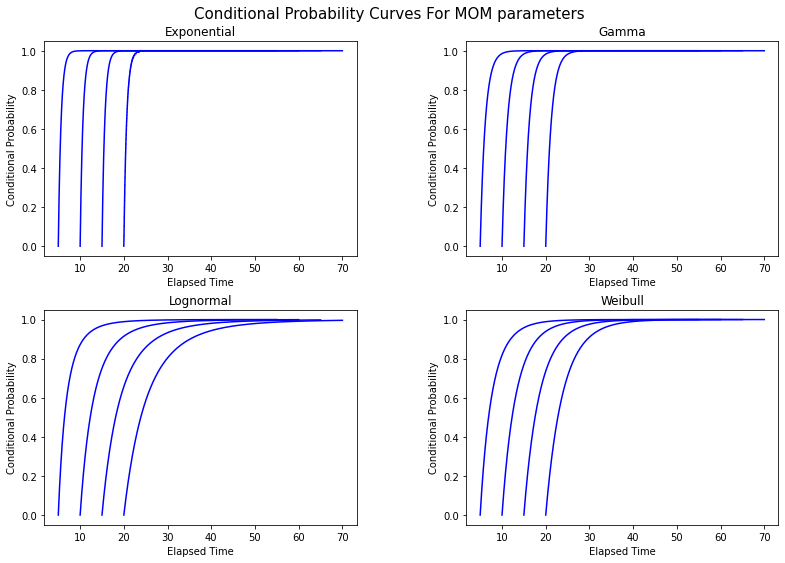

In [97]:
plot_mle([5, 10, 15, 20], v)
plot_mom([5, 10, 15, 20], v)

In [98]:
def get_tables_expo():
    v = np.arange(1, 20, 2)
    ts = np.arange(1, 20, 2)
    res = []
    for t in ts: 
        res.append(c_prob(v, cdf_exponential_mle, t))
    return res

def get_tables_weibull():
    v = np.arange(1, 20, 2)
    ts = np.arange(1, 20, 2)
    res = []
    for t in ts: 
        res.append(c_prob(v, cdf_weibull_mle, t))
    return res

In [99]:
res_expo = pd.DataFrame(get_tables_expo())
res_expo.columns = np.arange(1, 20, 2)
res_expo.index = np.arange(1, 20, 2)

In [100]:
res_weibull = pd.DataFrame(get_tables_weibull())
res_weibull.columns = np.arange(1, 20, 2)
res_weibull.index = np.arange(1, 20, 2)

In [101]:
res_weibull

,1,3,5,7,9,11,13,15,17,19
1,0.626521,0.936381,0.987562,0.997356,0.999404,0.999859,0.999966,0.999991,0.999998,0.999999
3,0.577573,0.917411,0.982447,0.996041,0.999066,0.999771,0.999942,0.999985,0.999996,0.999999
5,0.552189,0.904822,0.978536,0.994934,0.998759,0.999687,0.999919,0.999978,0.999994,0.999998
7,0.535013,0.895137,0.975248,0.993938,0.998469,0.999603,0.999895,0.999971,0.999992,0.999998
9,0.522063,0.887188,0.972373,0.993023,0.998191,0.999520,0.999870,0.999964,0.999990,0.999997
11,0.511691,0.880414,0.969798,0.992168,0.997922,0.999437,0.999845,0.999956,0.999988,0.999996
13,0.503055,0.874493,0.967456,0.991365,0.997662,0.999355,0.999819,0.999949,0.999985,0.999996
15,0.495667,0.869224,0.965300,0.990604,0.997409,0.999274,0.999793,0.999940,0.999983,0.999995
17,0.489218,0.864470,0.963299,0.989879,0.997162,0.999192,0.999767,0.999932,0.999980,0.999994
19,0.483501,0.860135,0.961429,0.989186,0.996922,0.999112,0.999740,0.999923,0.999977,0.999993


In [102]:
res_expo

,1,3,5,7,9,11,13,15,17,19
1,0.796954,0.991629,0.999655,0.999986,0.999999,1.0,1.0,1.0,1.0,1.0
3,0.796954,0.991629,0.999655,0.999986,0.999999,1.0,1.0,1.0,1.0,1.0
5,0.796954,0.991629,0.999655,0.999986,0.999999,1.0,1.0,1.0,1.0,1.0
7,0.796954,0.991629,0.999655,0.999986,0.999999,1.0,1.0,1.0,1.0,1.0
9,0.796954,0.991629,0.999655,0.999986,0.999999,1.0,1.0,1.0,1.0,1.0
11,0.796954,0.991629,0.999655,0.999986,0.999999,1.0,1.0,1.0,1.0,1.0
13,0.796954,0.991629,0.999655,0.999986,0.999999,1.0,1.0,1.0,1.0,1.0
15,0.796955,0.991630,0.999654,0.999986,1.000000,1.0,1.0,1.0,1.0,1.0
17,0.796987,0.991615,0.999672,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0
19,0.796502,0.992051,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0
